In [97]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from sklearn.metrics import mean_absolute_percentage_error

# Read the data
df = pd.read_csv("../Data/merged_cleaned.csv", delimiter=",")

# Clean up column names
df.columns = df.columns.str.strip().str.replace(" ", "_").str.replace("[MWh]", "")

# Drop 'date' column as it's redundant
df = df.drop('date', axis=1)

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# One-hot encode 'Holiday' and 'day_name' columns
df = pd.get_dummies(df, columns=['Holiday', 'day_name'], drop_first=True)

# Fill missing values with forward fill
df = df.fillna(method='ffill')

# # Add Last Year Value (same day, last year)
# df['Last_Year'] = df['Gesamt_(Netzlast)__Berechnete_Auflösungen'].shift(365 * 24)

# # Add Last Week Value (same day, last week)
# df['Last_Week'] = df['Gesamt_(Netzlast)__Berechnete_Auflösungen'].shift(168)

C:\Users\TimPr\AppData\Local\Temp\ipykernel_39876\618105036.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill')


In [98]:
df = df.dropna()

# Scale the features using MinMaxScaler
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df.drop(columns=['Date']))

# Add back the scaled data to the DataFrame
df_scaled = pd.DataFrame(scaled_features, columns=df.columns[1:])
df_scaled['Date'] = df['Date']

# Split the data into train, validation, and test
train = df_scaled[df_scaled['Date'] < '2023-10-30']
test = df_scaled[df_scaled['Date'] >= '2023-10-30']

# Optional: Split the train set into training and validation
val = train.tail(len(train)//10)
train = train.head(len(train) - len(val))


In [99]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from torch import nn

# Create dataset class for LSTM
class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size=48):
        self.data = data
        self.window_size = window_size
        self.features = data.drop(columns=['Date']).values
        self.target = data['Gesamt_(Netzlast)__Berechnete_Auflösungen'].values

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        x = self.features[idx:idx+self.window_size]
        y = self.target[idx+self.window_size]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# Set window size for LSTM (48 hours = 2 days of data)
window_size = 168

# Create datasets and dataloaders
train_dataset = TimeSeriesDataset(train, window_size)
val_dataset = TimeSeriesDataset(val, window_size)
test_dataset = TimeSeriesDataset(test, window_size)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=64)


In [100]:
# Check the size of the dataframes
print(f"Training set size: {len(train)}")
print(f"Validation set size: {len(val)}")
print(f"Test set size: {len(test)}")

# Check the min and max dates in each dataframe
print(f"Min and Max dates in Training set: {train['Date'].min()}, {train['Date'].max()}")
print(f"Min and Max dates in Validation set: {val['Date'].min()}, {val['Date'].max()}")
print(f"Min and Max dates in Test set: {test['Date'].min()}, {test['Date'].max()}")


Training set size: 39426
Validation set size: 4380
Test set size: 8814
Min and Max dates in Training set: 2018-11-01 00:00:00, 2023-04-30 18:00:00
Min and Max dates in Validation set: 2023-04-30 19:00:00, 2023-10-29 23:00:00
Min and Max dates in Test set: 2023-10-30 00:00:00, 2024-10-30 23:00:00


In [101]:
def check_for_nas(dataset, name):
    contains_nan = False
    for i in range(len(dataset)):
        x, y = dataset[i]
        if np.isnan(x).any() or np.isnan(y).any():
            contains_nan = True
            print(f"NaN found in {name} at index {i}")
            break
    if not contains_nan:
        print(f"No NaNs found in {name} dataset.")

# Check each dataset
check_for_nas(train_dataset, "Train")
check_for_nas(val_dataset, "Validation")
check_for_nas(test_dataset, "Test")


C:\Users\TimPr\AppData\Local\Temp\ipykernel_39876\2899205153.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  if np.isnan(x).any() or np.isnan(y).any():


No NaNs found in Train dataset.
No NaNs found in Validation dataset.
No NaNs found in Test dataset.


In [102]:
import torch
import pytorch_lightning as pl
from torch import nn

class LSTMModel(pl.LightningModule):
    def __init__(self, input_size, hidden_layer_size, output_size=1, num_layers=3, dropout=0.2):
        super(LSTMModel, self).__init__()
        # Multi-layer LSTM with dropout
        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers=num_layers, batch_first=True, dropout=dropout)

        # Batch normalization for LSTM output
        self.batch_norm = nn.BatchNorm1d(hidden_layer_size)

        # Additional fully connected layer
        self.fc1 = nn.Linear(hidden_layer_size, hidden_layer_size // 2)
        self.relu = nn.ReLU()

        # Final output layer
        self.fc2 = nn.Linear(hidden_layer_size // 2, output_size)

        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]  # Get the output of the last time step
        lstm_out = self.batch_norm(lstm_out)  # Apply batch normalization
        lstm_out = self.dropout(lstm_out)  # Apply dropout
        lstm_out = self.fc1(lstm_out)  # First fully connected layer
        lstm_out = self.relu(lstm_out)  # Apply ReLU activation
        lstm_out = self.dropout(lstm_out)  # Apply dropout again
        return self.fc2(lstm_out)  # Final output layer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat.squeeze(), y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = nn.MSELoss()(y_hat.squeeze(), y)
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        return y_hat.squeeze(), y

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)



In [103]:
torch.set_float32_matmul_precision('high')


In [104]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

# Define the model
model = LSTMModel(input_size=train_dataset.features.shape[1], hidden_layer_size=128)

# Initialize the TensorBoard logger
logger = TensorBoardLogger("tb_loggis", name="lstm_model")

# Define the callbacks
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",  # Metric to monitor
    dirpath="checkpoints",  # Directory to save the model
    filename="best_model-{epoch:02d}-{val_loss:.4f}",  # Naming convention
    save_top_k=1,  # Save only the best model
    mode="min",  # Minimize validation loss
)

early_stopping_callback = EarlyStopping(
    monitor="val_loss",  # Metric to monitor
    patience=10,  # Stop after 10 epochs of no improvement
    mode="min",  # Minimize validation loss
    verbose=True,
)

# Define the trainer
trainer = pl.Trainer(
    max_epochs=100,
    devices=1,
    accelerator="gpu",
    logger=logger,
    callbacks=[checkpoint_callback, early_stopping_callback],  # Add callbacks
)

# Train the model
trainer.fit(model, train_loader, val_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
c:\Users\TimPr\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:654: Checkpoint directory C:\Users\TimPr\allcode\energy-timeseries-project\3_Model\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type        | Params | Mode 
---------------------------------------------------
0 | lstm       | LSTM        | 354 K  | train
1 | batch_norm | BatchNorm1d | 256    | train
2 | fc1        | Linear      | 8.3 K  | train
3 | relu       | ReLU        | 0      | train
4 | fc2        | Linear      | 65     | train
5 | dropout    | Dropout     | 0      | train
---------------------------------------------------
362 K     Trainable params
0         Non-trainable params
362 K     Total params
1.452     Total estimated model params size (MB)
6         Modules in train mode
0         Mo

c:\Users\TimPr\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
c:\Users\TimPr\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████| 614/614 [00:04<00:00, 124.06it/s, v_num=8, val_loss=0.00295]

Metric val_loss improved. New best score: 0.003


Epoch 1: 100%|██████████| 614/614 [00:04<00:00, 128.25it/s, v_num=8, val_loss=0.00168]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.002


Epoch 2: 100%|██████████| 614/614 [00:04<00:00, 128.22it/s, v_num=8, val_loss=0.00108]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.001


Epoch 3: 100%|██████████| 614/614 [00:04<00:00, 129.71it/s, v_num=8, val_loss=0.000626]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.001


Epoch 12: 100%|██████████| 614/614 [00:04<00:00, 136.36it/s, v_num=8, val_loss=0.000483]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 16: 100%|██████████| 614/614 [00:04<00:00, 125.65it/s, v_num=8, val_loss=0.000462]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 17: 100%|██████████| 614/614 [00:05<00:00, 121.86it/s, v_num=8, val_loss=0.00037] 

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 18: 100%|██████████| 614/614 [00:04<00:00, 126.90it/s, v_num=8, val_loss=0.000333]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 25: 100%|██████████| 614/614 [00:04<00:00, 130.38it/s, v_num=8, val_loss=0.000291]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 27: 100%|██████████| 614/614 [00:04<00:00, 129.93it/s, v_num=8, val_loss=0.000278]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 32: 100%|██████████| 614/614 [00:04<00:00, 129.46it/s, v_num=8, val_loss=0.000228]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 34: 100%|██████████| 614/614 [00:04<00:00, 128.02it/s, v_num=8, val_loss=0.000215]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.000


Epoch 44: 100%|██████████| 614/614 [00:04<00:00, 127.88it/s, v_num=8, val_loss=0.000525]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.000. Signaling Trainer to stop.


Epoch 44: 100%|██████████| 614/614 [00:04<00:00, 127.81it/s, v_num=8, val_loss=0.000525]


In [105]:
# # Define the model and trainer
# model = LSTMModel(input_size=train_dataset.features.shape[1], hidden_layer_size=128)

# # Initialize the TensorBoard logger
# from pytorch_lightning.loggers import TensorBoardLogger
# logger = TensorBoardLogger("tb_loggis", name="lstm_model")

# trainer = pl.Trainer(max_epochs=100, devices=1, accelerator="gpu", logger=logger)

# # Train the model
# trainer.fit(model, train_loader, val_loader)


In [106]:
# Test the model on the test set
predictions, targets = [], []

model.eval()
with torch.no_grad():
    for x_batch, y_batch in test_loader:
        y_hat = model(x_batch)
        predictions.append(y_hat.squeeze().numpy())
        targets.append(y_batch.numpy())

predictions = np.concatenate(predictions)
targets = np.concatenate(targets)

# Calculate MAPE
mape = mean_absolute_percentage_error(targets, predictions)
print(f'MAPE on test data: {mape:.4f}')


MAPE on test data: 0.0628


In [107]:
# Calculate MAPE for "last hour prediction"
last_hour_predictions = targets[:-1]  # Use each target value except the last one as the prediction
actual_targets = targets[1:]  # Skip the first value to align with predictions

# Calculate MAPE
mape_last_hour = mean_absolute_percentage_error(actual_targets, last_hour_predictions)
print(f'MAPE for last hour prediction: {mape_last_hour:.4f}')


MAPE for last hour prediction: 0.0982


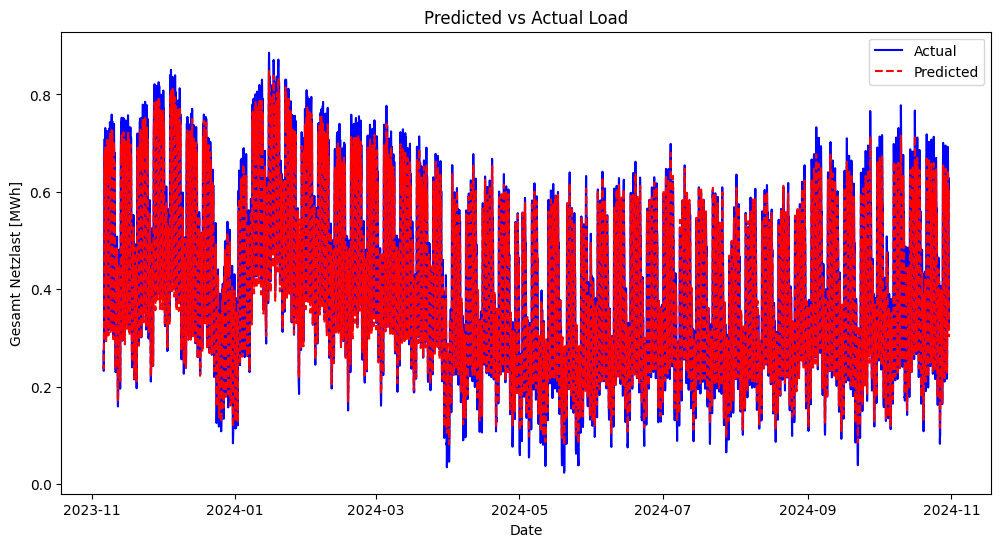

In [108]:
import matplotlib.pyplot as plt

# Convert to a DataFrame for plotting
pred_df = pd.DataFrame({'Date': test['Date'][window_size:].values, 'Actual': targets, 'Predicted': predictions})

plt.figure(figsize=(12, 6))
plt.plot(pred_df['Date'], pred_df['Actual'], label='Actual', color='blue')
plt.plot(pred_df['Date'], pred_df['Predicted'], label='Predicted', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Gesamt Netzlast [MWh]')
plt.title('Predicted vs Actual Load')
plt.legend()
plt.show()


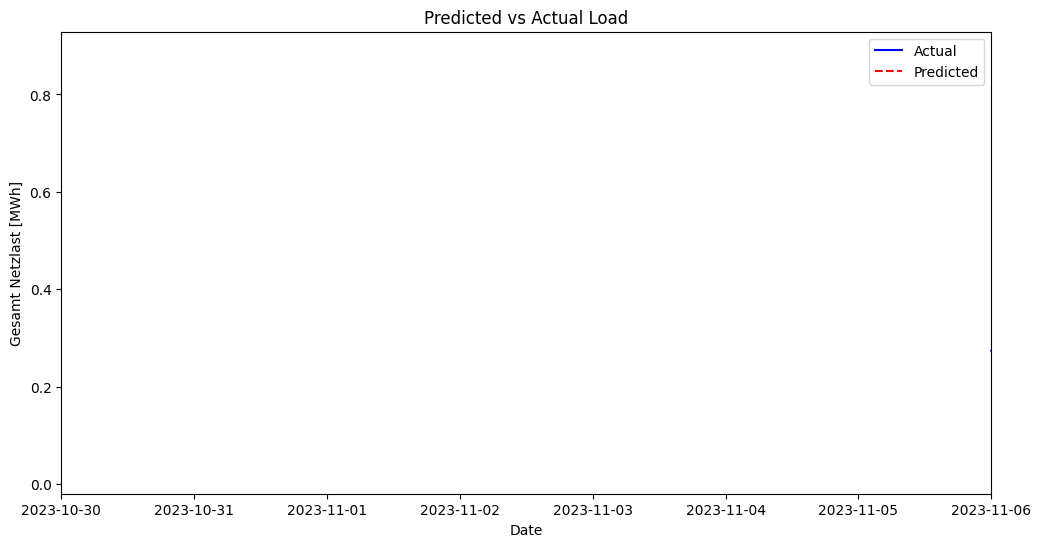

In [109]:
import matplotlib.pyplot as plt

# Convert to a DataFrame for plotting
pred_df = pd.DataFrame({'Date': test['Date'][window_size:].values, 'Actual': targets, 'Predicted': predictions})

# Plotting the full range
plt.figure(figsize=(12, 6))
plt.plot(pred_df['Date'], pred_df['Actual'], label='Actual', color='blue')
plt.plot(pred_df['Date'], pred_df['Predicted'], label='Predicted', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Gesamt Netzlast [MWh]')
plt.title('Predicted vs Actual Load')
plt.legend()

# Zoom in on one week (example: last week in the data)
zoom_start = pd.to_datetime('2023-10-30')
zoom_end = zoom_start + pd.Timedelta(days=7)

plt.xlim(zoom_start, zoom_end)  # Adjust the x-axis to the date range of the week

plt.show()
